In [ ]:
from pathlib import Path

import torch
import numpy as np
import imgaug
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [ ]:
class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params
    
    @staticmethod
    def extract_files(root):
        """
        Extract the paths to all slices given the root path (ends with train or val)
        """
        files = []
        for subject in root.glob("*"):  
            slice_path = subject/"data"  
            for slice in slice_path.glob("*.npy"):
                files.append(slice)
        return files
    
    
    @staticmethod
    def change_img_to_label_path(path):
        """
        Replace data with mask to get the masks
        """
        parts = list(path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)

    def augment(self, slice, mask):
        """
        Augments slice and segmentation mask in the exact same way
        Note the manual seed initialization
        """
        random_seed = torch.randint(0, 1000000, (1,)).item()
        imgaug.seed(random_seed)
        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()
        return slice_aug, mask_aug
    
    def __len__(self):
        """
        Return the length of the dataset (length of all files)
        """
        return len(self.all_files)
    
    
    def __getitem__(self, idx):
        """
        Given an index return the (augmented) slice and corresponding mask
        Add another dimension for pytorch
        """
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice = np.load(file_path).astype(np.float32) 
        mask = np.load(mask_path)
        
        if self.augment_params:
            slice, mask = self.augment(slice, mask)
        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)
        

In [ ]:
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa


In [ ]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15), 
               rotate=(-45, 45)),  
    iaa.ElasticTransformation()  
                ])


In [ ]:
path = Path("/content/drive/MyDrive/Colab Notebooks/Preprocessed/train")
dataset = CardiacDataset(path, seq)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


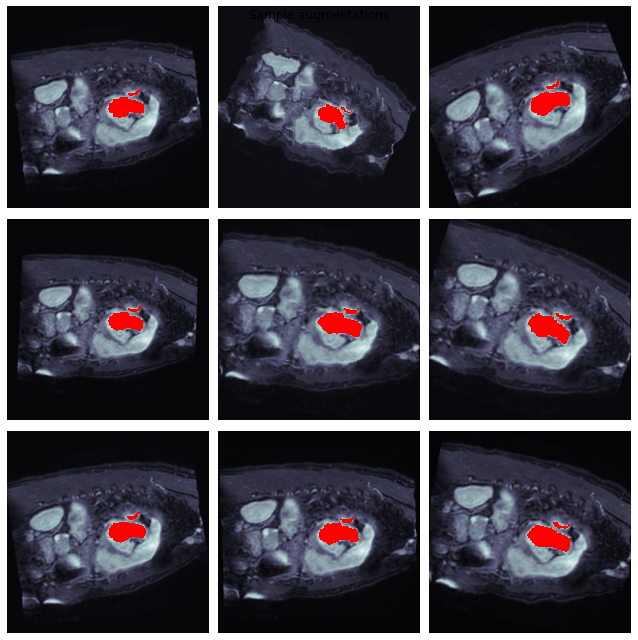

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        slice, mask = dataset[3]
        mask_ = np.ma.masked_where(mask==0, mask)
        axis[i][j].imshow(slice[0], cmap="bone")
        axis[i][j].imshow(mask_[0], cmap="autumn")
        axis[i][j].axis("off")

fig.suptitle("Sample augmentations")
plt.tight_layout()


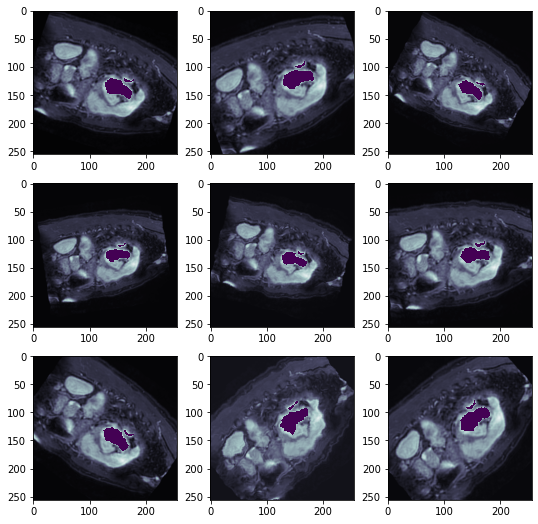

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        slice, mask = dataset[3]
        mask_ = np.ma.masked_where(mask==0, mask)
        axis[i][j].imshow(slice[0], cmap="bone")
        axis[i][j].imshow(mask_[0])
    